In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(ge_amp=0.8, ge_time=81.17534608287957, ro_amp=1, RO_LO=6.6247, ro_freq=6.72745, qubit_thr=[-10000, -600], ro_dur=4000, RO_LO_pwr=16, IQ_angle=205, ge_ssm=-0.1145, ef_time=49.13671850689116, ROIF=0.10275000000000034, ef_ssm=-0.2568, ef_amp=1.5, qubit_id=q1, RO_IF=None)
Qubit(ge_amp=0.8, ge_time=45.047198597262124, ro_amp=1.5, RO_LO=6.6247, ro_freq=6.6556, qubit_thr=[-10000, 1900], ro_dur=4000, RO_LO_pwr=16, IQ_angle=85, ge_ssm=-0.154, ef_time=None, ROIF=0.030899999999999928, ef_ssm=-0.2962, ef_amp=1, qubit_id=q2, RO_IF=None)


In [3]:
def run_rabi_ef_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(
        q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_J(J_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 51
    reps = 12000
    sweep_time = 20000
    swap_freq = -0.0195
    swap_time = 0.5 * 6 / abs(swap_freq)

    # Create an array of frequency values
    J_vals = J_list

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value

        a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.5
        # if J is in units of rad/micros
        J_to_a = 1 / a_to_J
        ef_amp = J * J_to_a
        q1.ef_amp = ef_amp
        df_prob, df_pop, values = run_rabi_ef_swap(
            q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time, reps
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [4]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.2
# if J is in units of rad/micros
J_to_a = 1 / a_to_J

In [5]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}

    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df["time"].values
        P_f = df["P_f"].values
        P_e = df["P_e"].values

        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1

        guess_gamma = np.sqrt(abs(0.25**2 - J**2))
        guess_freq = np.sqrt(abs(0.25**2 - J**2)) / np.pi
        # Select initial guess values based on J
        if J <= 0.1:
            P_f_norm = P_f / norm_factor
            # P_f_norm = P_f
            guess_vals = [0.0000001, 0.0477, 0.1, -10, 0.5]
        else:
            P_f_norm = P_f / norm_factor
            guess_vals = [guess_freq, 0.2, 0.1, -10, 0.5]
        guess_vals = [guess_freq, guess_gamma, 0.1, -10, 0.5]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_decay(
            times, P_f_norm, guess_vals=guess_vals
        )

        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)

        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

In [6]:
def fit_func(J, J0):
    """
    Model function: Re(sqrt(2*(J^2 - J0^2))).
    Returns sqrt(2*(J^2 - J0^2)) if the argument is non-negative;
    otherwise returns 0.

    Parameters:
        J : array_like
            The independent variable.
        J0 : float
            The parameter to fit.

    Returns:
        array_like : The computed model values.
    """
    expr = 2 * (J**2 - J0**2)
    return np.where(expr >= 0, np.sqrt(expr), 0.0)


def curve_fit_function(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(sqrt(2*(J^2 - J0^2)))
    using the provided initial guess for J0.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            Optimal value for J0.
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_J0])
    return popt, pcov


def curve_fit_and_plot(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the given data to the model function (without offset) and plots the original data
    (scatter plot) along with the fitted curve.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            The optimal parameter (J0) from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameter.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_J0)
    fitted_J0 = popt[0]
    print("Fitted J0 =", fitted_J0)

    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_J0)

    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30)
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.xlabel("J")
    plt.ylabel("Re(sqrt(2*(J^2 - J0^2)))")
    plt.title("Curve Fit: Data and Fitted Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return popt, pcov

In [7]:
def run_rabi_ef_no_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    ef_amp: float,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_no_swap.rabi_ef_no_swap(
        q1,
        q2,
        general_vals_dict,
        ef_amp,
        num_steps,
        sweep_time,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    return values


def run_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    swap_freq: float,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    return values

In [ ]:
J_start = 0
J_stop = 1
J_steps = 201
# J_list = np.linspace(10, 10,1)#
J_list = np.linspace(J_start, J_stop, J_steps)
J_dict, vals_dict = sweep_J(J_list)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4


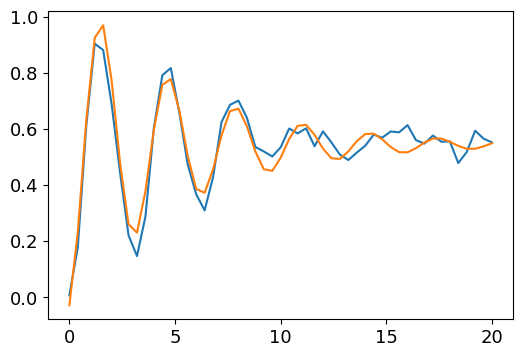



  freq: 0.31358392579431243 +/- 0.0026982900229503004
 gamma: 0.186579974565215 +/- 0.015828730223402507
   amp: -0.5813940751970114 +/- 0.03269567524431633
 phase: 99.46044214907118 +/- 3.6568202097267264
offset: 0.5446493809182199 +/- 0.006660061681137796
pi_pulse time: 1.5944694828776478 +/- 0.0026982900229503004
J = 1.0: Angular freq (rad/µs): 1.9703059151185176
J = 1.0: omega = 1.9703059151185176 rad/µs


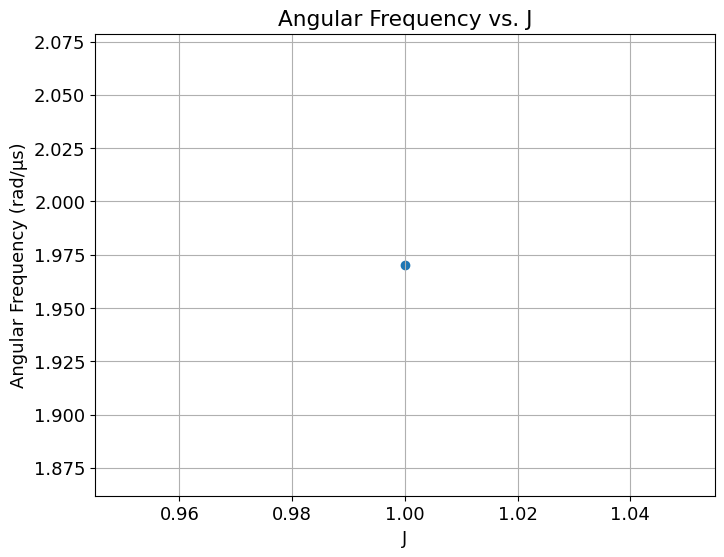

Fitted J0 = -2.2354197250435207e-07


C:\Users\quantum1\AppData\Local\Temp\ipykernel_27472\909373872.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, np.sqrt(expr), 0.0)
C:\Users\quantum1\AppData\Local\Temp\ipykernel_27472\909373872.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_J0])


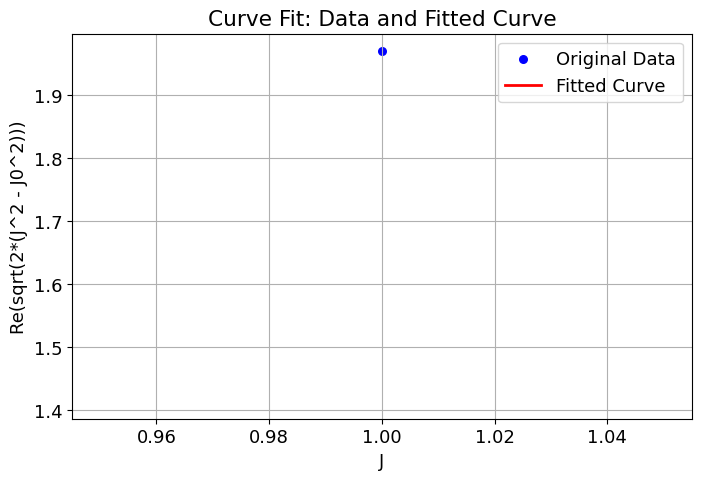

In [ ]:
# Now call the function to process each J value and extract the angular frequency
probs_folder = os.path.join("sweep_J_data", "probs")
values_folder = os.path.join("sweep_J_data", "values")
probability_dataframes = {}
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

    # If both files already exist, load them and skip this iteration
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
# probability_dataframes = 0
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]

plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()
# Set initial guesses based on your expectations:
initial_guess_J0 = 0.1  # for example
initial_offset = 0.0  # for example
mask_rb = ~np.isnan(omegas)

# Perform the curve fitting and plotting
popt, pcov = curve_fit_and_plot(
    np.array(J_vals)[mask_rb], np.array(omegas)[mask_rb], initial_guess_J0
)

<Figure size 960x720 with 0 Axes>

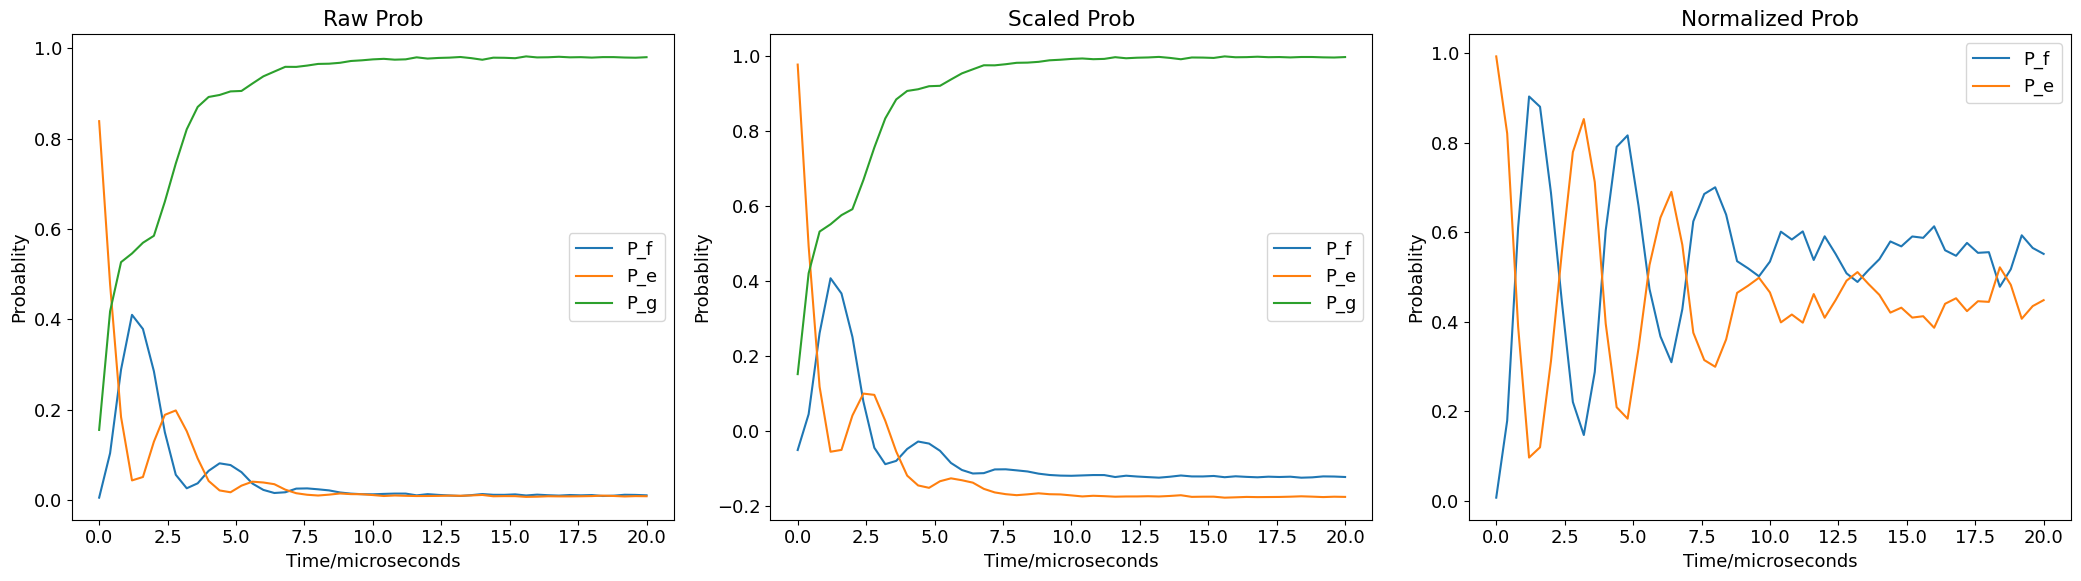

In [ ]:
scale_matrix = np.array(
    [
        [1.01788813, -0.0081921, -0.00969603],
        [-0.19047774, 1.201006, -0.01052826],
        [-0.13825531, -0.04327379, 1.18152911],
    ]
)
J = 1
measured_pop = np.array(
    [
        probability_dataframes[J]["P_g"],
        probability_dataframes[J]["P_e"],
        probability_dataframes[J]["P_f"],
    ]
)
scaled_p = np.matmul(scale_matrix, measured_pop)
scaled_df = pd.DataFrame(
    {
        "time": probability_dataframes[J]["time"],
        "P_g": scaled_p[0],
        "P_e": scaled_p[1],
        "P_f": scaled_p[2],
    }
)
normalization_val = probability_dataframes[J]["P_f"] + probability_dataframes[J]["P_e"]
normalized_df = pd.DataFrame(
    {
        "time": probability_dataframes[J]["time"],
        "P_f": probability_dataframes[J]["P_f"] / normalization_val,
        "P_e": probability_dataframes[J]["P_e"] / normalization_val,
        "P_g": probability_dataframes[J]["P_g"] / normalization_val,
    }
)
keys = ["P_f", "P_e", "P_g"]
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(data=probability_dataframes[J], x="time", y=key, ax=axes[0], label=key)
    sns.lineplot(data=scaled_df, x="time", y=key, ax=axes[1], label=key)
    if "P_g" != key:
        sns.lineplot(data=normalized_df, x="time", y=key, ax=axes[2], label=key)
axes[1].set_xlabel("Time/microseconds")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Scaled Prob")
axes[1].legend()
axes[0].set_xlabel("Time/microseconds")
axes[0].set_ylabel("Probablity")
axes[0].set_title("Raw Prob")
axes[0].legend()
axes[2].set_xlabel("Time/microseconds")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Normalized Prob")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()

In [ ]:
num_steps = 51
sweep_time = 20000
J_start = J_list[0]
J_stop = J_list[-1]
J_steps = len(J_list)
J_vals = np.linspace(J_start, J_stop, J_steps)
p_f = np.zeros((J_steps, num_steps))
for i in range(J_steps):
    p_f[i] = probability_dataframes[J_vals[i]]["P_f"] / (
        probability_dataframes[J_vals[i]]["P_f"]
        + probability_dataframes[J_vals[i]]["P_e"]
    )
plt.imshow(p_f, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("time (microseconds)")
plt.title("P_f")
plt.show()

ValueError: could not broadcast input array from shape (76,) into shape (51,)